In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("List available databases and tables").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

[Database(name='2022_10_22', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='2023_04_01', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='default', catalog='spark_catalog', description='Default Hive database', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse')]

In [2]:
spark.sql("SHOW TABLES IN 2023_04_01").show(10)

+----------+--------------------+-----------+
| namespace|           tableName|isTemporary|
+----------+--------------------+-----------+
|2023_04_01|  affiliate_type_map|      false|
|2023_04_01|     asset_class_map|      false|
|2023_04_01|      audit_type_map|      false|
|2023_04_01|ca_div_freq_qual_map|      false|
|2023_04_01|     ca_div_type_map|      false|
|2023_04_01|   ca_event_type_map|      false|
|2023_04_01| ce_audio_source_map|      false|
|2023_04_01|   ce_event_type_map|      false|
|2023_04_01|ce_fiscal_period_map|      false|
|2023_04_01|  ce_market_time_map|      false|
+----------+--------------------+-----------+
only showing top 10 rows



In [3]:
imploded_stocks = pd.read_csv('filtered_tickers.csv')
imploded_stocks = imploded_stocks['Ticker'].tolist()
sp500_stocks = pd.read_csv('spx500.csv', usecols=['Symbol'])
sp500_stocks = sp500_stocks['Symbol'].tolist()

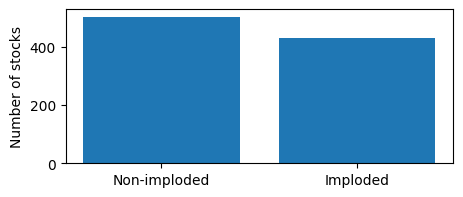

In [16]:
import matplotlib.pyplot as plt

def plot_imploded_vs_normal():
    categories = ['Non-imploded', 'Imploded']
    vals = [len(sp500_stocks), len(imploded_stocks)]
    plt.figure(figsize=(5,2))
    plt.bar(categories, vals)
    plt.ylabel('Number of stocks')
    plt.show()

plot_imploded_vs_normal()

In [4]:
import random

random_seed = 42
random.seed(random_seed)
combined_stocks = imploded_stocks + sp500_stocks
#random.shuffle(combined_stocks)
combined_stocks = sorted(combined_stocks)


In [5]:
import yfinance as yf
from datetime import datetime

def pull_stock_monthly(stock_list, start_date='2009-01-01', end_date=datetime.now().strftime('%Y-%m-%d')):
    all_series = []
    for t in stock_list:
        df = yf.download(t, start=start_date, end=end_date, progress=False)
        if not(df.empty):
            monthly_df = df['Adj Close'].resample('M').last().to_frame()
            monthly_df['Ticker'] = t
            all_series.append(monthly_df)
    combined_df = pd.concat(all_series, axis=0)
    combined_df.to_csv('imploded_sp500.csv')
        

#pull_stock_monthly(combined_stocks)
#with (filtered) imploded stocks and sp500 stocks the total number of rows of data is 134,523 (monthly)

In [6]:
import os
def get_data(filename):
    pandas_df = pd.read_csv(filename)
    pandas_df = pandas_df[["Ticker", "Date", "Adj Close"]]
    pandas_df = pandas_df.rename(columns={"Adj Close": "Price"})
    spark_df = spark.createDataFrame(pandas_df)
    spark_df.show(10)
    
    return spark_df



In [7]:
def pull_fundamental(ticker, start_date, end_date):
    spark.sql("USE 2023_04_01")
    # Assuming that 'ticker' is a valid Python variable

    query = f"""SELECT d.ticker_region, a.date, a.ff_assets 
                FROM FF_BASIC_QF a 
                LEFT JOIN sym_ticker_region d ON d.fsym_id = a.fsym_id 
                WHERE d.ticker_region = "{ticker}-US" 
                AND a.date >= "{start_date}" AND a.date <= "{end_date}"
                ORDER BY a.date"""

    df = spark.sql(query)
    #print(df.show(10,False))
    return df

def add_fundamental(spark_df):
    unique_tickers_df = spark_df.select("Ticker").distinct()
    unique_tickers = [row.Ticker for row in unique_tickers_df.collect()]
    unique_tickers = unique_tickers[:10]
    full_fund_df = None
    for t in unique_tickers:
        print(t)
        filtered_df = spark_df.filter(spark_df["Ticker"] == t)
        start_date = filtered_df.agg({"Date": "min"}).collect()[0][0]
        end_date = filtered_df.agg({"Date": "max"}).collect()[0][0]
        fund_df = pull_fundamental(t, start_date, end_date)
        if full_fund_df is None:
            full_fund_df = fund_df
        else:
            full_fund_df = full_fund_df.union(fund_df)
    full_fund_df.show(100)
        
        
    
#pull_fundamental('ABEO')
# stock_df = get_data('imploded_sp500.csv')
# add_fundamental(stock_df)
#get sp500 stocks
#get imploded stocks
#randomise order
#get monthly dates
#returns
    